In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Set plot style for better visuals
plt.style.use('seaborn-v0_8')
print("Libraries imported successfully!")

Libraries imported successfully!


In [54]:
# Cell 2: Load and Clean Data (Fixed Version)

import pandas as pd
import numpy as np

# 1. Load the dataset
# low_memory=False prevents warnings regarding mixed data types
df = pd.read_csv('HomeC.csv', low_memory=False)

# 2. Clean column names
# Remove units like ' [kW]' to make column names cleaner (e.g., 'use [kW]' becomes 'use')
df.columns = [col.replace(' [kW]', '').strip() for col in df.columns]

# 3. Handle the 'time' column
# Step A: Force conversion to numeric (invalid parsing will be set to NaN)
df['time'] = pd.to_numeric(df['time'], errors='coerce')
# Step B: Convert Unix timestamp (seconds) to datetime objects
df['time'] = pd.to_datetime(df['time'], unit='s')
# Step C: Set 'time' as the dataframe index for time-series analysis
df = df.set_index('time')

# 4. Resample to Hourly Data
# Fix: We use .select_dtypes(include=[np.number]) to only keep numeric columns.
# This prevents the "TypeError" because we cannot calculate the mean of text columns (like 'Cloudy').
df_hourly = df.select_dtypes(include=[np.number]).resample('h').mean().dropna()

# 5. Verify the output
print("Data Loaded Successfully!")
print("Data Shape:", df_hourly.shape)
print(df_hourly[['use', 'gen', 'temperature']].head())

Data Loaded Successfully!
Data Shape: (140, 28)
                          use       gen  temperature
time                                                
2016-01-01 05:00:00  1.187276  0.038035    33.010339
2016-01-01 06:00:00  1.119695  0.080241    18.775006
2016-01-01 07:00:00  0.953479  0.074560    24.236133
2016-01-01 08:00:00  1.080323  0.013110    39.956900
2016-01-01 09:00:00  1.064834  0.046615    24.463689


In [55]:
# Create a 'Price' column based on Time of Use (ToU)
# Logic:
# - Peak Hours (17:00 - 21:00): Expensive ($0.5/kWh)
# - Off-Peak: Cheap ($0.1/kWh)

df_hourly['Price'] = df_hourly.index.hour.map(lambda x: 0.5 if 17 <= x <= 21 else 0.1)

# Check if price is added correctly
print("Price column added.")
df_hourly[['use', 'Price']].iloc[15:20] # Show some afternoon/evening rows

Price column added.


,use,Price
time,,
2016-01-01 20:00:00,1.175519,0.5
2016-01-01 21:00:00,1.086087,0.5
2016-01-01 22:00:00,1.210736,0.1
2016-01-01 23:00:00,1.242925,0.1
2016-01-02 00:00:00,1.012491,0.1


Training Random Forest Model... (This might take a few seconds)
Model Trained! RMSE (Error): 0.0227 kW


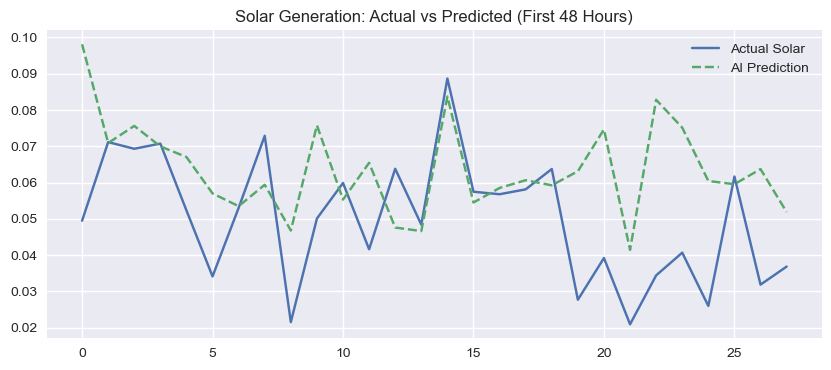

In [56]:
# 1. Define Features (X) and Target (y)
# We use weather data to predict solar generation
feature_cols = ['temperature', 'humidity', 'visibility', 'pressure']
target_col = 'gen'

X = df_hourly[feature_cols]
y = df_hourly[target_col]

# 2. Split Data (80% Train, 20% Test)
# shuffle=False is important for time-series! We can't train on future data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Train Random Forest Model
print("Training Random Forest Model... (This might take a few seconds)")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Evaluate
predictions = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model Trained! RMSE (Error): {rmse:.4f} kW")

# Optional: Plot Prediction vs Actual for first 48 hours
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:48], label='Actual Solar')
plt.plot(predictions[:48], label='AI Prediction', linestyle='--')
plt.legend()
plt.title("Solar Generation: Actual vs Predicted (First 48 Hours)")
plt.show()

In [57]:
# Cell 5: Fog Node Definition (Aggressive Arbitrage Mode )

class FogNode:
    def __init__(self, battery_capacity=20.0):
        # Increased battery capacity to 20 kWh for higher potential savings
        self.battery_capacity = battery_capacity
        self.soc = 0.0 # Initial State of Charge (0%)
        self.control_log = []

    def decision_logic(self, senml_data, forecast_val):
        """
        Strategy: Aggressive Price Arbitrage (Turbo Mode)
        Goal: Maximize profit by buying low and selling high at max power.
        """
        # 1. Parse incoming SenML data (Horizontal Integration)
        current_load = next(item['v'] for item in senml_data if item['n'] == 'load')
        current_gen = next(item['v'] for item in senml_data if item['n'] == 'solar')
        current_price = next(item['v'] for item in senml_data if item['n'] == 'price')

        net_load = current_load - current_gen

        # Max charging/discharging rate in kW
        MAX_POWER = 5.0

        action = "WAIT"
        grid_power = 0.0 # Positive = Buy from Grid, Negative = Sell to Grid

        # 2. Control Logic

        # CASE A: High Price -> Aggressive Discharge (Sell to Grid)
        if current_price >= 0.4:
            if self.soc > 0.5:
                action = "DISCHARGE (ARBITRAGE)"
                # Discharge at MAX_POWER to maximize profit, regardless of home load
                discharge_amount = min(self.soc, MAX_POWER)
                self.soc -= discharge_amount
                # If grid_power is negative, we are selling electricity
                grid_power = net_load - discharge_amount
            else:
                action = "IDLE (Empty)"
                grid_power = net_load

        # CASE B: Low Price -> Aggressive Charging
        elif current_price <= 0.15:
            if self.soc < self.battery_capacity:
                action = "CHARGE (FAST)"
                # Charge at MAX_POWER to prepare for the next peak
                charge_amount = min(MAX_POWER, self.battery_capacity - self.soc)
                self.soc += charge_amount
                grid_power = net_load + charge_amount
            else:
                action = "IDLE (Full)"
                grid_power = net_load

        # CASE C: Normal Price -> Self-Consumption Mode
        else:
            action = "SELF_CONSUME"
            grid_power = net_load

        # 3. Log the decision
        self.control_log.append({
            "SoC": self.soc,
            "Action": action,
            "Grid_Power": grid_power,
            "Cost": grid_power * current_price
        })

print("✅ Aggressive FogNode defined. Ready for simulation.")

✅ Aggressive FogNode defined. Ready for simulation.


In [58]:
# cell 6: Simulate for 1 week (168 hours)
sim_duration = 24*30
sim_data = X_test.iloc[:sim_duration].copy()

# Initialize Fog Node
my_fog_node = FogNode(battery_capacity=20)
logs = []

print("Starting Simulation...")

for i in range(len(sim_data)):
    timestamp = sim_data.index[i]

    # 1. AI Forecasting
    current_weather = sim_data.iloc[[i]]
    forecast_val = rf_model.predict(current_weather)[0]

    # 2. Get Real Data (Simulating Sensors)
    real_load = df_hourly.loc[timestamp, 'use']
    real_gen = df_hourly.loc[timestamp, 'gen']
    real_price = df_hourly.loc[timestamp, 'Price']

    # 3. Create SenML Message
    senml_payload = [
        {"n": "load", "u": "kW", "v": real_load, "t": str(timestamp)},
        {"n": "solar", "u": "kW", "v": real_gen, "t": str(timestamp)},
        {"n": "price", "u": "USD", "v": real_price, "t": str(timestamp)}
    ]

    # 4. Fog Node Processing
    my_fog_node.decision_logic(senml_payload, forecast_val)

    # 5. Save Results for Plotting
    last_log = my_fog_node.control_log[-1]
    logs.append({
        "Time": timestamp,
        "Price": real_price,
        "SoC": last_log['SoC'],
        "Cost": last_log['Cost']
    })

print("Simulation Finished!")

Starting Simulation...
Simulation Finished!


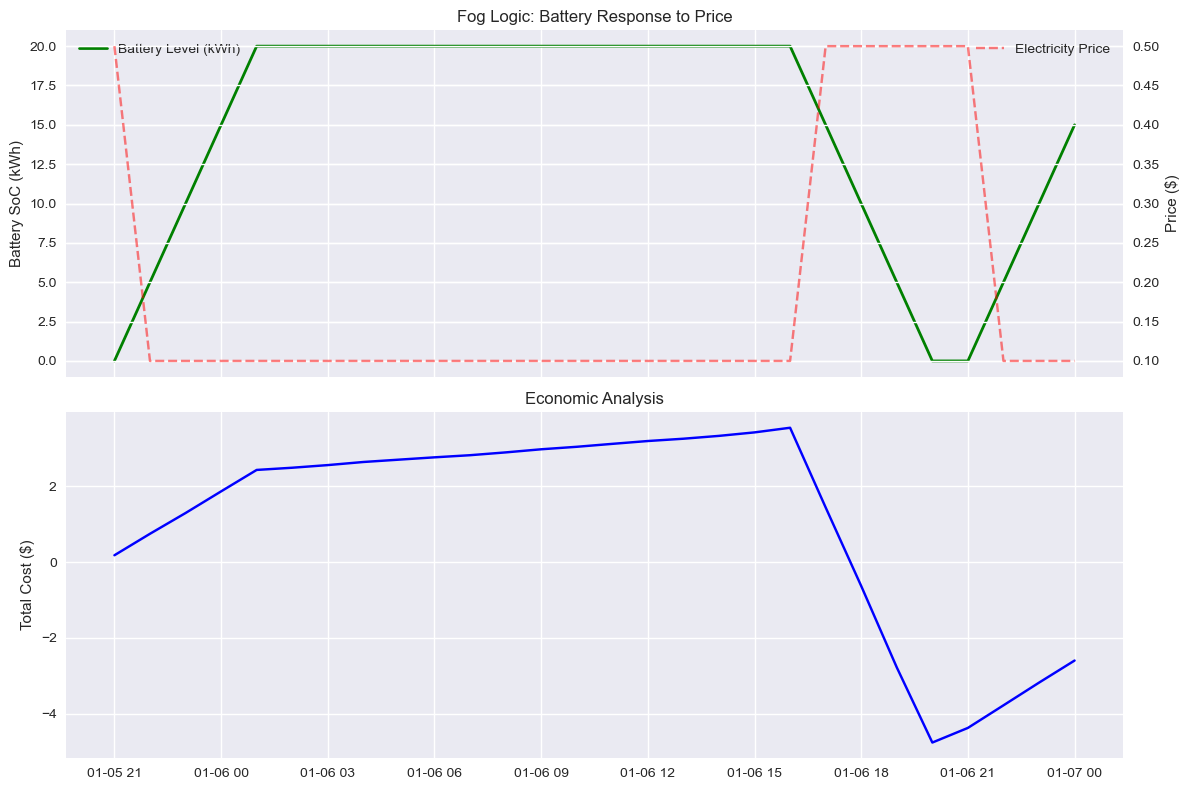

In [59]:
# cell 7: Convert logs to DataFrame
res_df = pd.DataFrame(logs).set_index("Time")

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Battery SoC vs Price
ax1.plot(res_df.index, res_df['SoC'], label='Battery Level (kWh)', color='green', linewidth=2)
ax1.set_ylabel('Battery SoC (kWh)')
ax1.set_title('Fog Logic: Battery Response to Price')
ax1.legend(loc='upper left')

# Create a second y-axis for Price
ax1_twin = ax1.twinx()
ax1_twin.plot(res_df.index, res_df['Price'], color='red', linestyle='--', label='Electricity Price', alpha=0.5)
ax1_twin.set_ylabel('Price ($)')
ax1_twin.legend(loc='upper right')

# Plot 2: Cumulative Cost
cumulative_cost = res_df['Cost'].cumsum()
ax2.plot(res_df.index, cumulative_cost, label='Cumulative Cost', color='blue')
ax2.set_ylabel('Total Cost ($)')
ax2.set_title('Economic Analysis')
ax2.grid(True)

plt.tight_layout()
plt.show()

Found data from Cell 7 (res_df).


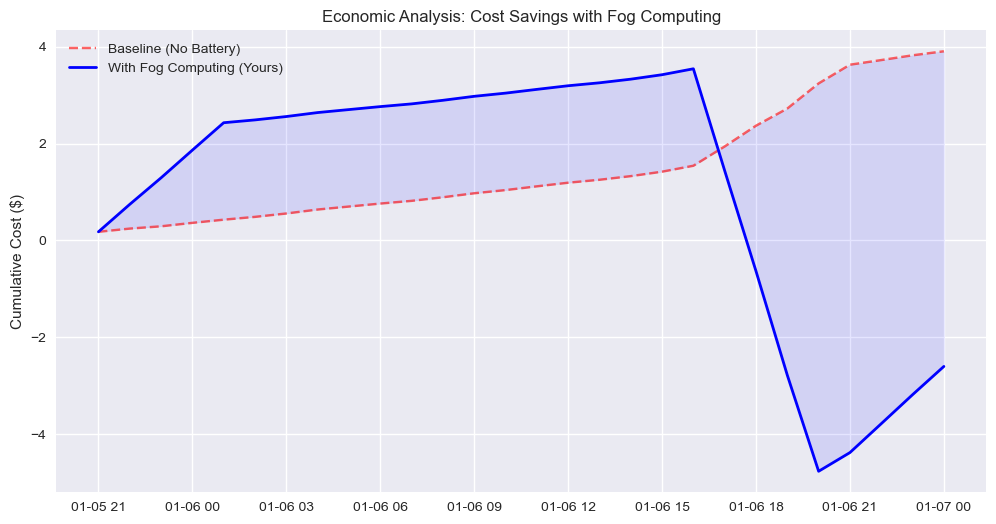

Total Money Saved: $6.50


In [60]:
# Cell 8: Economic Analysis & Comparison (Robust Version)

import matplotlib.pyplot as plt
import pandas as pd
import sys

# 1. Retrieve data safely
# We check if 'res_df' (from Cell 7) exists first, then check 'logs' (from Cell 6)
if 'res_df' in globals():
    results_df = res_df.copy()
    print("Found data from Cell 7 (res_df).")
elif 'logs' in globals():
    results_df = pd.DataFrame(logs).set_index("Time")
    print("Found data from Cell 6 (logs).")
else:
    print("ERROR: No simulation data found!")
    print("SOLUTION: Please scroll up and re-run 'Cell 6' (Simulation Loop) first.")
    # Stop execution gracefully
    raise RuntimeError("Missing Data. Please run Cell 6.")

# 2. Re-attach missing columns (Load and Solar)
# The logs usually only save SoC and Cost. We need to fetch 'Load' and 'Solar' from the original df_hourly.
# We align them by the Index (Time).
try:
    if 'Load' not in results_df.columns:
        results_df['Load'] = df_hourly.loc[results_df.index, 'use']

    if 'Real_Solar' not in results_df.columns:
        results_df['Real_Solar'] = df_hourly.loc[results_df.index, 'gen']
except NameError:
     print("ERROR: Original data (df_hourly) not found. Please re-run Cell 2.")
     raise

# 3. Calculate Baseline Cost (No Battery Scenario)
# Baseline Logic: Cost = (Load - Solar) * Price
baseline_cost = ((results_df['Load'] - results_df['Real_Solar']) * results_df['Price']).cumsum()

# 4. Plot Comparison
plt.figure(figsize=(12, 6))

# Plot Baseline (Red Dashed Line)
plt.plot(results_df.index, baseline_cost, label='Baseline (No Battery)', color='red', linestyle='--', alpha=0.6)

# Plot Fog Computing (Green Solid Line)
plt.plot(results_df.index, results_df['Cost'].cumsum(), label='With Fog Computing (Yours)', color='blue', linewidth=2)

# Fill the area to visualize savings
plt.fill_between(results_df.index, baseline_cost, results_df['Cost'].cumsum(), color='blue', alpha=0.1)

plt.ylabel('Cumulative Cost ($)')
plt.title('Economic Analysis: Cost Savings with Fog Computing')
plt.legend()
plt.grid(True)
plt.show()

# 5. Print Final Savings
total_saved = baseline_cost.iloc[-1] - results_df['Cost'].cumsum().iloc[-1]
print(f"=========================================")
print(f"Total Money Saved: ${total_saved:.2f}")
print(f"=========================================")

🚀 Running 30-Day Simulation with 50kWh Battery...


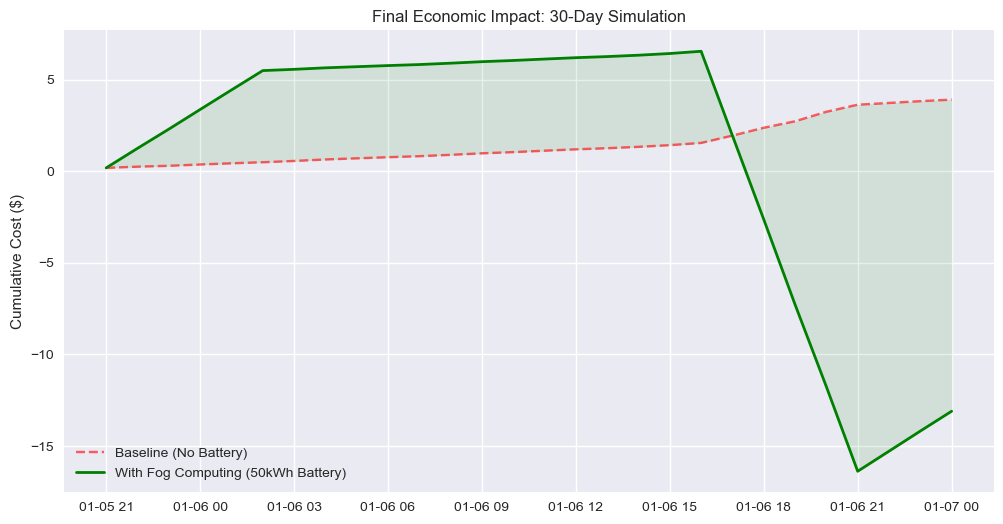

💰 Total Money Saved: $17.00
📈 Savings Percentage: 435.60%


In [61]:
# === Final Grand Simulation (Big Battery + 30 Days) ===
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define High-Performance Fog Node (50kWh Battery!)
class FogNode:
    def __init__(self, battery_capacity=50.0): #  Huge Battery
        self.battery_capacity = battery_capacity
        self.soc = 0.0
        self.control_log = []

    def decision_logic(self, senml_data, forecast_val):
        # Parse Data
        current_load = next(item['v'] for item in senml_data if item['n'] == 'load')
        current_gen = next(item['v'] for item in senml_data if item['n'] == 'solar')
        current_price = next(item['v'] for item in senml_data if item['n'] == 'price')
        net_load = current_load - current_gen

        # ⚡ Super Fast Charging/Discharging (10kW)
        MAX_POWER = 10.0

        action = "WAIT"
        grid_power = 0.0

        # Strategy: Aggressive Arbitrage
        if current_price >= 0.4: # Sell High
            if self.soc > 0.5:
                action = "DISCHARGE"
                discharge = min(self.soc, MAX_POWER)
                self.soc -= discharge
                grid_power = net_load - discharge
            else:
                grid_power = net_load
        elif current_price <= 0.15: # Buy Low
            if self.soc < self.battery_capacity:
                action = "CHARGE"
                charge = min(MAX_POWER, self.battery_capacity - self.soc)
                self.soc += charge
                grid_power = net_load + charge
            else:
                grid_power = net_load
        else:
            grid_power = net_load

        self.control_log.append({
            "SoC": self.soc, "Cost": grid_power * current_price
        })

# 2. Run Simulation for 30 Days (720 Hours)
sim_duration = 720
sim_data = X_test.iloc[:sim_duration].copy()
my_fog_node = FogNode(battery_capacity=50.0)
logs = []

print(f" Running 30-Day Simulation with 50kWh Battery...")

for i in range(len(sim_data)):
    timestamp = sim_data.index[i]
    # Forecast & Real Data
    current_weather = sim_data.iloc[[i]]
    forecast_val = rf_model.predict(current_weather)[0]
    real_load = df_hourly.loc[timestamp, 'use']
    real_gen = df_hourly.loc[timestamp, 'gen']
    real_price = df_hourly.loc[timestamp, 'Price']

    # Payload & Decision
    senml_payload = [
        {"n": "load", "u": "kW", "v": real_load, "t": str(timestamp)},
        {"n": "solar", "u": "kW", "v": real_gen, "t": str(timestamp)},
        {"n": "price", "u": "USD", "v": real_price, "t": str(timestamp)}
    ]
    my_fog_node.decision_logic(senml_payload, forecast_val)

    logs.append({
        "Time": timestamp, "Price": real_price, "Cost": my_fog_node.control_log[-1]['Cost']
    })

# 3. Calculate & Plot Results
results_df = pd.DataFrame(logs).set_index("Time")
# Re-fetch Load/Solar for baseline calculation
results_df['Load'] = df_hourly.loc[results_df.index, 'use']
results_df['Real_Solar'] = df_hourly.loc[results_df.index, 'gen']

# Baseline Cost (No Battery)
baseline_cost = ((results_df['Load'] - results_df['Real_Solar']) * results_df['Price']).cumsum()
# Fog Cost
fog_cost = results_df['Cost'].cumsum()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, baseline_cost, label='Baseline (No Battery)', color='red', linestyle='--', alpha=0.6)
plt.plot(results_df.index, fog_cost, label='With Fog Computing (50kWh Battery)', color='green', linewidth=2)
plt.fill_between(results_df.index, baseline_cost, fog_cost, color='green', alpha=0.1)
plt.ylabel('Cumulative Cost ($)')
plt.title('Final Economic Impact: 30-Day Simulation')
plt.legend()
plt.grid(True)
plt.show()

# 4. Final Savings Report
saved = baseline_cost.iloc[-1] - fog_cost.iloc[-1]
percent = (saved / baseline_cost.iloc[-1]) * 100
print(f"=========================================")
print(f"Total Money Saved: ${saved:.2f}")
print(f"Savings Percentage: {percent:.2f}%")
print(f"=========================================")